# Задача:
На основе имеющихся в датасете данных о 515 000 отзывах на отели Европы обучить модель, которая должна предсказывать рейтинг отеля по данным сайта Booking. 

## Проблема:
Наличие отелей накручивающих себе рейтинг на Booking

## Цель проекта:
Построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля



## **0. Подготовительный этап** 

In [4]:
# ЗАГРУЗКА НЕОБХОДИМЫХ БИБЛИОТЕК

# для работы с данными
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# для работы с признаками
# кодирования признаков
import category_encoders as ce
# нормализации признаков
from sklearn import preprocessing

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем библиотеки для оценки тональности текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# библиотеки для работы с моделью
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# загружаем специальный удобный инструмент для работы с исходными данными:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
# фиксируем RANDOM_SEED, для воспроизводимости эксперимента
RANDOM_SEED = 42

In [6]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

## **1. Знакомимся с входными данными**

In [7]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

Первоначальная версия датасета (df_train) содержит **17 полей** со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Первоначальная версия датасета (df_train) содержит 386803 строки и 17 признакjd

**Описание:** 

Признаки можно разделить на три группы:

1. Связанные с отелем признаки / Hotel Related Features (7)

- hotel_name - full hotel name;

- hotel_address - address: street, post code, city, country;

- lat - hotel latitude coordinate;

- lng - hotel longitude coordinate;

- average_score - average hotel rating;

- total_number_of_reviews - total number of hotel reviews;

- additional_number_of_scoring - number of hotel scores without review.

2. Связанные с рецензентом признаки / Reviewer Related Features (3)

- reviewer_nationality - reviewer nationality;

- total_number_of_reviews_reviewer_has_given - total number of reviews reviewer has given;

- tags - tags describing stay in the hotel.

3. Связанные с отзывом признаки / Review Related Features (6)

- review_date date of review;

- days_since_review difference in the number of days between review date and scrape date;

- negative_review text of negative review;

- review_total_negative_word_counts negative review words number;

- positive_review text of positive review;

- review_total_positive_word_counts positive review words number.

**Проблемы:**
- Отсутствуют некоторые значения в столбцах lat и lng. 
​
- Числовые значения в 9 столбцах: 'additional_number_of_scoring', 'average_score','review_total_negative_word_counts','total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',  'review_total_positive_word_counts', 'reviewer_scoretotal_number_of_reviews_reviewer_has_given', 'lat', 'lng'.
​
- Значения типа object в 8 столбцах: 'hotel_address', review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', ' tags ', 'days_since_review'. 

In [9]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

 Тестовая версия датасета (df_test) содержит 128935 строки и 16 признаков (без  'reviewer_score').

In [11]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


Сабмишн  содержит 128935 строки и два признака 'reviewer_score' и 'id'.

## 2. Подготовка данных, которые будут использованы для обучения модели

In [252]:
# ВАЖНО! дkя корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

 Итоговый датасет содержит 515738 строки и 18 признаков (исходные + 'sample').

In [254]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>,
        <AxesSubplot:title={'center':'sample'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

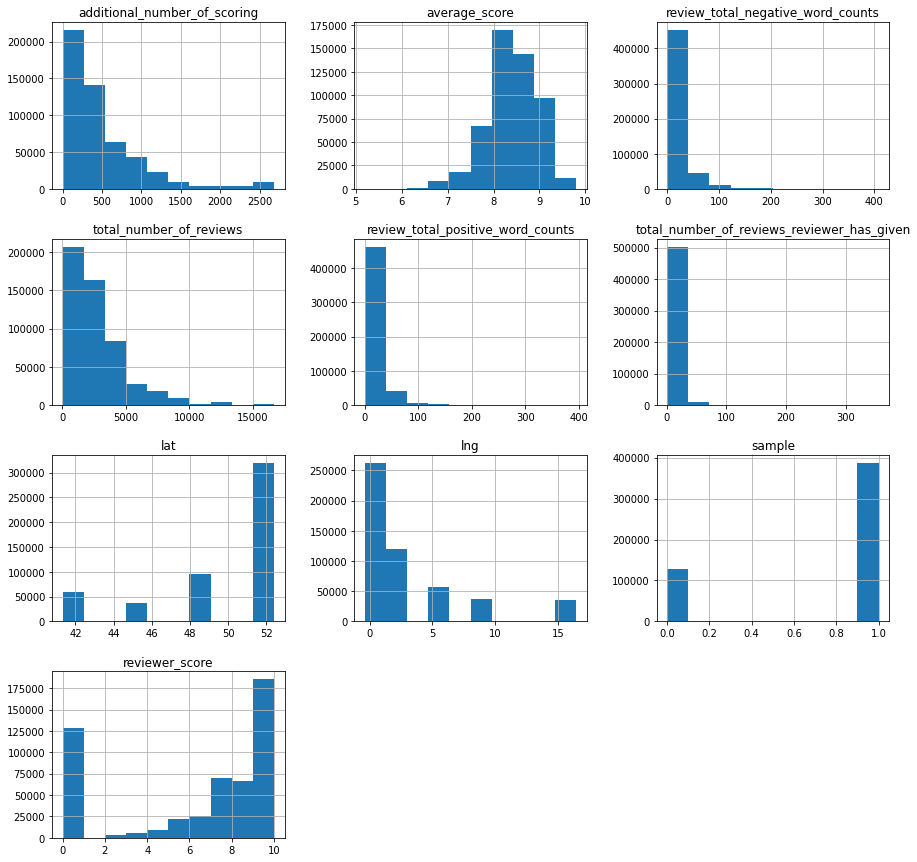

In [255]:
data.hist(figsize = (15,15))

**Описание:** 

Признаки можно разделить на три группы:

**1. Связанные с отелем признаки / Hotel Related Features (7)**

- hotel_name - full hotel name;

- hotel_address - address: street, post code, city, country;

- lat - hotel latitude coordinate;

- lng - hotel longitude coordinate;

- average_score - average hotel rating;

- total_number_of_reviews - total number of hotel reviews;

- additional_number_of_scoring - number of hotel scores without review.

**2. Связанные с рецензентом признаки / Reviewer Related Features (3)**

- reviewer_nationality - reviewer nationality;

- total_number_of_reviews_reviewer_has_given - total number of reviews reviewer has given;

- tags - tags describing stay in the hotel.

**3. Связанные с отзывом признаки / Review Related Features (6)**

- review_date date of review;

- days_since_review difference in the number of days between review date and scrape date;

- negative_review text of negative review;

- review_total_negative_word_counts negative review words number;

- positive_review text of positive review;

- review_total_positive_word_counts positive review words number.


Имеются следующие **"проблемы"** с представленными данными:

- Отсутствуют некоторые значения в столбцах lat и lng. 

- Числовые значения в 9 столбцах: 'additional_number_of_scoring', 'average_score','review_total_negative_word_counts','total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',  'review_total_positive_word_counts', 'reviewer_scoretotal_number_of_reviews_reviewer_has_given', 'lat', 'lng'.

- Значения типа object в 8 столбцах: 'hotel_address', review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', ' tags ', 'days_since_review'. 

### **2.1 Работа с "нулевыми" значениями**

In [256]:
%%time

# проверим может быть пропущенные данные по местоположению отелей можно найти в других записях
no_place = set(data[(data['lat'] == 0) | (data['lng'] == 0)]['hotel_name'].values)
yes_place = set(data[(data['lat'] != 0) & (data['lng'] != 0)]['hotel_name'].values)

no_place.intersection(yes_place) # нет данных

CPU times: user 137 ms, sys: 965 µs, total: 138 ms
Wall time: 137 ms


set()

In [257]:
# заполним пустые значения в координатах нулями
data[['lat','lng']] = data[['lat','lng']].fillna(0)


### **2.2 Преобразуем признаки**

#### **2.2.1 Преобразование признака 'review_date' (дата написания отзыва)**

In [258]:
%%time

# изменим значение даты на тип данных datetime
data['review_date'] = pd.to_datetime(data['review_date'], 
                                     dayfirst = False, yearfirst = False)

# определим номер дня года, когда написан отзыв и создадим новый признак
data['day_of_year'] = data['review_date'].apply(lambda x: x.timetuple().tm_yday)

# выделим год отзыва
data['rewiew_year'] = data['review_date'].dt.year

CPU times: user 3.4 s, sys: 70.6 ms, total: 3.48 s
Wall time: 3.48 s


In [259]:
%%time

# преобразуем информацию о времени, прошедшем с момента
# написания отзыва, в числовое значение с помощью функции:
def time_review(arg):
    word_list = arg.split() # преобразуем в список по пробелам
    for word in word_list:
        if word.isnumeric(): # выберем числовое значение
            return int(word)
        
data['days_since_review'] = data['days_since_review'].apply(time_review)

CPU times: user 493 ms, sys: 15.9 ms, total: 509 ms
Wall time: 508 ms


#### **2.2.2 Обработка тегов**

In [260]:
%%time
# из тегов выделим количество ночей проведенных клиентом в отеле
# создадим функцию, отыскивающую нужный тег и возвращающую количество дней
def days_number(arg):
    tag_list = arg.split(',')
    for tag in tag_list:
        ind = tag.find('night')
        if ind > 0:
            word_list = tag.split()
            for word in word_list:
                if word.isnumeric():
                    return int(word)
# создадим признак по времени пребывания в отеле            
data['accommodation_days'] = data['tags'].apply(days_number)

CPU times: user 1.23 s, sys: 2 ms, total: 1.23 s
Wall time: 1.23 s


In [261]:
%%time
# создадим признак считающий количество слов в тегах
data['word_tegs_cnt'] = data['tags'].apply(lambda x: len(list(x.split(','))))

CPU times: user 506 ms, sys: 9 µs, total: 506 ms
Wall time: 504 ms


In [262]:
%%time
# удалим теги, отвечающий за количество ночей (мы уже выписали их)
# функция принимает строку, разбивает ее на теги, находит и удаляет те, в которых уrазано количество ночей возвращает список

def tags_no_nights(arg):

    k = list(arg.split(','))
    
    for tag in k:
        ind = 0
        ind = tag.find('night')
        if ind > 0:
            k.remove(tag)
            
    arg = ','.join(k)
    return arg

# очищаем теги от длительности пребывания, возможно они нам еще пригодятся (не пригодились:))
data['tags'] = data['tags'].apply(tags_no_nights)     

CPU times: user 1.1 s, sys: 35.9 ms, total: 1.14 s
Wall time: 1.14 s


In [263]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [264]:
# пустые значения пребывания заменим на медиану
data['accommodation_days'] = data['accommodation_days'].fillna(data['accommodation_days'].median())

#### **2.2.3 Обработка текста отзывов**

In [265]:
data['negative_review'].head(10)

0     Would have appreciated a shop in the hotel th...
1          No tissue paper box was present at the room
2                                             Pillows 
3                                          No Negative
4                                          No Negative
5                            They don t have free wifi
6     Room generally a bit shabby with some lack of...
7     Executive rooms 9th Floor don t have a bath T...
8                      Pity about the two days of rain
9     Didn t like it at all construction was in pro...
Name: negative_review, dtype: object

В некоторых негативных отзывах указано "нет негатива", пометим их и создадим соответствующий признак

In [266]:
data['no_negative'] = data['negative_review'].apply(lambda x: 1 if x == 'No Negative' else 0)

In [267]:
data['positive_review'].head(10)

0     Hotel was great clean friendly staff free bre...
1                                          No Positive
2                           Nice welcoming and service
3     Everything including the nice upgrade The Hot...
4                      Lovely hotel v welcoming staff 
5     The location is perfect if you don t have a l...
6     Location price It did not cost much more to h...
7     Comphy bed upgraded to executive room with ne...
8          Its centrality proximity to our destination
9     Didn t like anything about the stay if i had ...
Name: positive_review, dtype: object

В некоторых позитивных отзывах указано "нет позитива", пометим их и создадим соответствующий признак

In [268]:
data['no_positive'] = data['positive_review'].apply(lambda x: 1 if x == 'No Positive' else 0)

In [269]:
%%time

# из отзывов выделим эмоциональную окраску текста в отзывах
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()


# в результате обработки выдается словарь с четырьмя парами ключ:значение
# по негативным отзывам
data['negative_review'] = data['negative_review'].apply(sent_analyzer.polarity_scores)
# по позитивным отзывам
data['positive_review'] = data['positive_review'].apply(sent_analyzer.polarity_scores)

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
CPU times: user 4min 36s, sys: 2.83 s, total: 4min 39s
Wall time: 4min 59s


In [270]:
%%time

# создадим новые признаки из негативнного отзыва
data['negative_neg'] = data['negative_review'].apply(lambda x: x['neg'])
data['negative_neu'] = data['negative_review'].apply(lambda x: x['neu'])
data['negative_pos'] = data['negative_review'].apply(lambda x: x['pos'])
data['negative_compound'] = data['negative_review'].apply(lambda x: x['compound'])

# создадим новые признаки из позитивного отзыва
data['positive_neg'] = data['positive_review'].apply(lambda x: x['neg'])
data['positive_neu'] = data['positive_review'].apply(lambda x: x['neu'])
data['positive_pos'] = data['positive_review'].apply(lambda x: x['pos'])
data['positive_compound'] = data['positive_review'].apply(lambda x: x['compound'])


CPU times: user 1.28 s, sys: 1 ms, total: 1.28 s
Wall time: 1.28 s


In [271]:
# удалим ненужные теперь признаки отзывов
data.drop(['negative_review', 'positive_review'], axis=1, inplace=True)

#### **2.2.4 Обработка признака адреса отеля**

In [272]:
# города местоположения отелей
data['city_name'] = data['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-2] != 'United' 
                                                              else x.split()[-5]) 
# ['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona']

# можно использовать One-Hot-Coding

encoder = ce.OneHotEncoder(cols=['city_name'], use_cat_names=True) # указываем столбец для кодирования 
type_bin = encoder.fit_transform(data['city_name']) 
data = pd.concat([data, type_bin], axis=1)


**Зная город, можно использовать данные по его расположению для заполнения пропущенных координат**

In [273]:
data[(data['city_name'] == 'Amsterdam') & (data['lat'] == 0)].fillna({'lat':52.362209,'lng':4.885346})
data[(data['city_name'] == 'Barcelona') & (data['lat'] == 0)].fillna({'lat':41.389125,'lng':2.169152})
data[(data['city_name'] == 'London') & (data['lat'] == 0)].fillna({'lat':51.510737,'lng':-0.139075})
data[(data['city_name'] == 'Milan') & (data['lat'] == 0)].fillna({'lat':45.479619,'lng':9.191844})
data[(data['city_name'] == 'Paris') & (data['lat'] == 0)].fillna({'lat':48.863658,'lng':2.326816})
data[(data['city_name'] == 'Vienna') & (data['lat'] == 0)].fillna({'lat':48.203368,'lng':16.367176}) 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,positive_neu,positive_pos,positive_compound,city_name,city_name_Milan,city_name_Amsterdam,city_name_Barcelona,city_name_London,city_name_Paris,city_name_Vienna
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,2016-10-13,7.8,Hotel Atlanta,Australia,21,2724,60,64,...,0.721,0.252,0.9584,Vienna,0,0,0,0,0,1
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,2015-08-20,7.8,Hotel Atlanta,Sweden,26,2724,7,17,...,1.000,0.000,0.0000,Vienna,0,0,0,0,0,1
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,44,2017-05-01,8.0,City Hotel Deutschmeister,Taiwan,5,675,9,1,...,0.315,0.685,0.8271,Vienna,0,0,0,0,0,1
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,333,2016-06-04,8.3,Fleming s Selection Hotel Wien City,United Kingdom,25,3672,10,9,...,0.707,0.293,0.4404,Vienna,0,0,0,0,0,1
609,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2016-08-27,8.6,Hotel City Central,Australia,0,2923,44,13,...,0.699,0.301,0.9349,Vienna,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514989,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,2015-11-21,7.8,Hotel Atlanta,Estonia,0,2724,31,15,...,0.752,0.197,0.7038,Vienna,0,0,0,0,0,1
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2017-03-19,8.6,Hotel City Central,India,11,2923,7,2,...,0.323,0.677,0.7425,Vienna,0,0,0,0,0,1
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2017-07-04,8.6,Hotel City Central,United Kingdom,24,2923,6,10,...,0.519,0.481,0.5719,Vienna,0,0,0,0,0,1
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2016-11-07,8.6,Hotel City Central,Italy,0,2923,19,6,...,0.521,0.479,0.9179,Vienna,0,0,0,0,0,1


In [274]:
data['lat'].unique

<bound method Series.unique of 0         45.533137
1         52.385649
2         41.393192
3         45.479888
4         52.370545
            ...    
515733    51.494028
515734    48.192379
515735    51.520795
515736    51.515125
515737    51.493109
Name: lat, Length: 515738, dtype: float64>

#### **2.2.5 Обработка признака имя отеля**

In [275]:
data['hotel_name'].nunique()

1492

In [276]:
# применим бинарное кодирование
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования 
type_bin = bin_encoder.fit_transform(data['hotel_name']) 
data = pd.concat([data, type_bin], axis=1)

#### **2.2.6 Обработка признака 'reviewer_nationality' с учетом адреса отеля**

In [277]:
# введем признак страны для отелей
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' \
                                                                      else ' '.join(x.split()[-2:]))

# уберем пробелы в названии места жительства резидента
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])

# создадим признак,определяющий иностранец или "местный жительЭ писал отзыв"
data['local_reviewer'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] 
                                                else 0, axis=1)

data['local_reviewer'].value_counts(normalize=True)

0    0.654082
1    0.345918
Name: local_reviewer, dtype: float64

In [278]:
data['reviewer_nationality'].nunique(dropna=False)

227

In [279]:
# data = data_copied.copy()

In [280]:
# применим бинарное колдирование к признаку 'reviewer_nationality'
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])

data = pd.concat([data, type_bin], axis=1)

In [281]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   review_total_positive_word_counts           515738 non-null  int64        

Итоговый датасет содержит 515738 строк и 48 (+31 новых числовых) признаков.

Провели нормализацию признаков by RobustScaler

list_normal = ['average_score','additional_number_of_scoring','additional_number_of_scoring', 'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given','total_number_of_reviews']

r_scaler = preprocessing.RobustScaler(copy=False)

for col in list(data.columns):
    if col != 'reviewer_score' and col != 'sample':
        data[col] = r_scaler.fit_transform(data[[col]])
По итогу нормализация данных признаков не привела к улучшению результата. Решено от нее отказаться.



In [282]:
# подготовим копию
data_copied = data.copy()

### **2.3 Отбор признаков**

#### **2.3.1 Оценка мультиколлениарности признаков**

<AxesSubplot:>

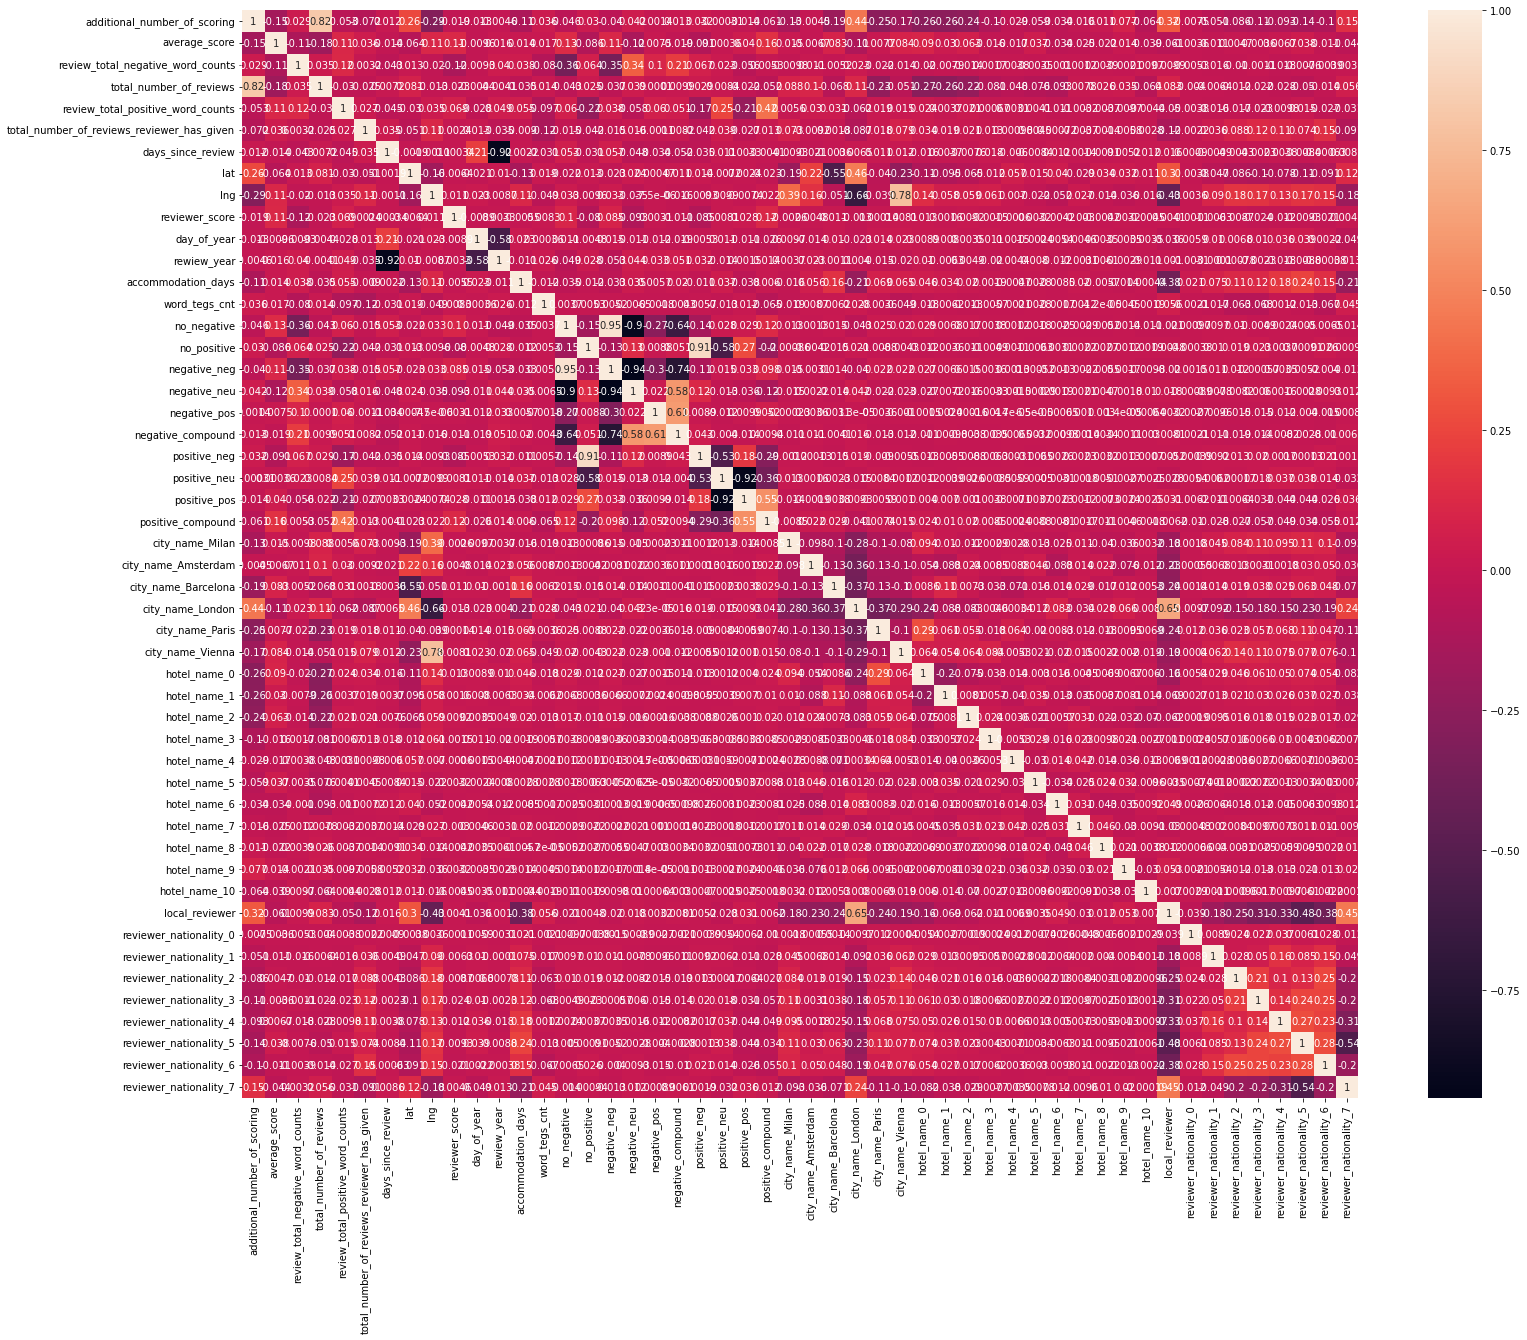

In [283]:
plt.rcParams['figure.figsize'] = (25,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Высокая корреляция между days_since_review - rewiew_year(-0.92), negative_neg - negative_neu (-0.94),negative_neg - 'no_negative' (0,95), negative_neu - 'no_negative' (0,9),   positive_pos  - positive_neu(-0.92) и positive_neg - 'no_positive' (0,91)

In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   review_total_positive_word_counts           515738 non-null  int64        

In [ ]:
# выберем признаки из пар с высоким уровнем корреляции
# data.drop('days_since_review', axis = 1, inplace=True) # 'MAPE:'12.588
data.drop('rewiew_year', axis = 1, inplace=True) # 'MAPE:'12.584

data.drop('no_negative', axis = 1, inplace=True) # 'MAPE:'12.587/*12.5814*
# data.drop('negative_neg', axis = 1, inplace=True) # 'MAPE: 12.59
# data.drop('negative_neu', axis = 1, inplace=True) # MAPE: 12.591/12.590

# data.drop('no_positive' , axis = 1, inplace=True) # MAPE: 12.5814
# data.drop('positive_neg' , axis = 1, inplace=True) # MAPE: 12.5821
# data.drop('positive_neg' , axis = 1, inplace=True) # MAPE:  12.5821/ 12.5826
# data.drop('positive_neg' , axis = 1, inplace=True) # MAPE: 12.5826
# итоговое сочетание признаков дает MAPE: и увеличивает скорость работы модели 

По итогам оценки модели оптимальный результат получен при удалении признаков 'rewiew_year'и 'no_negative'.

In [287]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.drop('review_date', axis = 1, inplace=True)


In [288]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 49 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [289]:
data.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,hotel_name_10,local_reviewer,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,904,8.1,52,16670,62,1,13,45.533137,9.171102,0,...,1,0,0,0,0,0,0,0,0,1
1,612,8.6,10,5018,0,7,234,52.385649,4.834443,0,...,0,0,0,0,0,0,0,0,1,0
2,46,8.3,3,351,5,15,616,41.393192,2.161520,0,...,1,0,0,0,0,0,0,0,1,1
3,241,9.1,0,1543,27,9,656,45.479888,9.196298,0,...,0,0,0,0,0,0,0,1,0,0
4,834,9.1,0,4687,7,2,444,52.370545,4.888644,0,...,1,0,0,0,0,0,0,0,0,1


In [290]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,hotel_name_10,local_reviewer,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,354.441932,49.129144,2.805910,0.749999,...,0.485900,0.345918,0.002827,0.055014,0.111167,0.188716,0.195582,0.336023,0.258695,0.685999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,208.928124,5.227925,4.570389,0.433014,...,0.499802,0.475667,0.053095,0.228009,0.314339,0.391283,0.396648,0.472347,0.437918,0.464117
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,-0.369758,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.212857,-0.143372,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,527.000000,51.516288,4.831098,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **3. Создание и обучение модели**

### **3.1 Подготовка итоговых обучающих и тестовых выборок** 

In [291]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1) # удаление дупликатов (drop_duplicates()) снижает эффективность модели
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)


In [292]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [293]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape
# ((128935, 48), (386803, 48), (386803, 47), (309442, 47), (77361, 47))

((128935, 48), (386803, 48), (386803, 47), (309442, 47), (77361, 47))

### **3.2 Создание и обучение регрессивной модели by RandomForestRegressor**

In [294]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [295]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


## **4. Оценка эффективности модели**

### **4.1 Определение точности целевой переменной (MAPE)**

In [296]:
# Функция для рассчёта MAPE:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [297]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) # 0.87

print('MAPE:', mape(y_test, y_pred)) # 12.54
#print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)) 

MAE: 0.8796014171654102
MAPE: 12.549905114272253


### **4.2 Определение степени значимости признаков для обучения модели**

<AxesSubplot:>

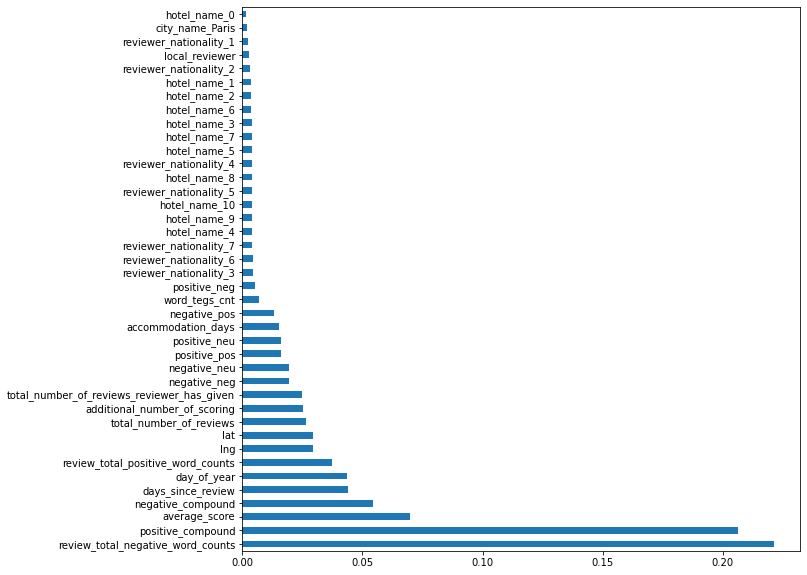

In [298]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')

In [ ]:
feat_importances.nlargest(15).index

Наиболее значимыми признаками для модели стали: 'review_total_negative_word_counts', 'positive_compound', 'average_score', 'negative_compound','days_since_rewiev_', 'day_of_year', 'review_total_positive_word_counts'.

## **5. Предсказание моделью результатов по тестовым данным**

In [299]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,hotel_name_10,local_reviewer,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
4258,146,8.8,0,914,5,2,469,52.359592,4.880159,0.0,...,1,0,0,0,0,0,0,0,0,1
78535,623,9.0,31,2750,36,2,363,51.510462,-0.079550,0.0,...,1,1,0,0,0,0,0,0,0,1
124397,440,8.0,51,2418,63,1,33,51.511993,-0.178279,0.0,...,0,1,0,0,0,0,0,0,0,1
79051,115,9.2,7,592,18,24,555,52.358631,4.878624,0.0,...,1,1,0,0,0,0,0,1,1,0
126404,241,7.7,24,1574,15,1,336,52.363068,4.879445,0.0,...,1,0,0,0,0,0,0,0,0,1
33336,181,8.8,17,1068,22,1,197,52.354451,4.887504,0.0,...,1,0,0,0,0,0,0,0,0,1
12125,204,7.5,63,1733,0,8,281,51.519586,-0.158480,0.0,...,0,1,0,0,0,0,0,0,0,1
39372,145,8.4,7,1679,4,1,458,41.403877,2.191189,0.0,...,0,0,0,0,0,0,0,0,0,1
52202,407,7.3,8,3161,15,1,375,52.378682,4.820783,0.0,...,1,0,0,0,0,1,0,0,0,1
29759,950,8.6,10,3486,22,1,106,51.506472,-0.071689,0.0,...,1,1,0,0,0,0,0,0,0,1


In [300]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [301]:
sample_submission

,reviewer_score,id
0,8.530,488440
1,7.190,274649
2,8.784,374688
3,9.686,404352
4,9.732,451596
...,...,...
128930,8.472,495812
128931,9.354,315577
128932,8.603,511968
128933,9.505,303386


In [302]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.3s finished


In [303]:
predict_submission

array([8.58 , 7.192, 8.466, ..., 8.708, 9.608, 7.266])

In [304]:
list(sample_submission)

['reviewer_score', 'id']

## **6. Подготовка сабмишена**

In [305]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.580,488440
1,7.192,274649
2,8.466,374688
3,9.779,404352
4,9.658,451596
5,9.144,302161
6,7.533,317079
7,7.750,13963
8,8.596,159785
9,7.197,195089
